In [1]:
import IPython.display as display
import sys
sys.path.append('../algorithms/py')

In [82]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score

In [5]:
import rutils as rt
import genetic as gn

# DATA LOADING

In [6]:
edata_df = pd.read_csv('../mutual-data/merged_edata.tsv', sep='\t', index_col=0)
mdata_df = pd.read_csv('../mutual-data/merged_mdata.tsv', sep='\t', index_col=0)
print( np.all(edata_df.columns == mdata_df.index) )

with open('../wgcna/common_genes.txt') as f:
	filter_genes = f.readlines()

gene_names = np.array([l for line in filter_genes if (l:=line.strip()) != ''])
print(f'{gene_names.size=}')

edata_df = edata_df.loc[gene_names,]
X = edata_df.T.to_numpy()
y = np.int_(mdata_df.condition == 'SC')

True
gene_names.size=101


# Apply model

In [7]:
svm = SVC(C=1, random_state=335, kernel='linear', class_weight='balanced', probability=True)
mdl = gn.GeneticModel(
    X, y,
    model=svm, 
    w1=0.05, w2=0.92, w3=0.03,
    total_pop=100,
    mutation_rate=(0.25, 0.05), swap_mrate=0.20,
    kappa=20, exploration_rate=0.4,
    elite_factor=(0.08, 0.30), elite_pop_var=8,
    evolve_gen=150,
    random_state=5430894,
    n_jobs=1
)

tournament_size - 8
Explorating agents...
N elites -  28
Mutation rate -  0.04999999999999999
itration - 299
0.95150 | Total gene - 19
{'f1': 0.8119, 'f2': 0.9614, 'f3': 0.8802, 'var_oob': 0.0064, 'mean_boot': 1.0, 'var_boot': 0.0}
['ACTN4' 'ALDH3A1' 'BAG6' 'BBLN' 'CD81' 'CLTB' 'ECH1' 'FGFR3' 'GCLM'
 'HRAS' 'HYOU1' 'MRPL12' 'NDUFV1' 'NUMA1' 'PIR' 'POLR2E' 'RNF40'
 'SLC25A11' 'ZNF444']
global best — 0.9515 | 19
['ACTN4' 'ALDH3A1' 'BAG6' 'BBLN' 'CD81' 'CLTB' 'ECH1' 'FGFR3' 'GCLM'
 'HRAS' 'HYOU1' 'MRPL12' 'NDUFV1' 'NUMA1' 'PIR' 'POLR2E' 'RNF40'
 'SLC25A11' 'ZNF444']


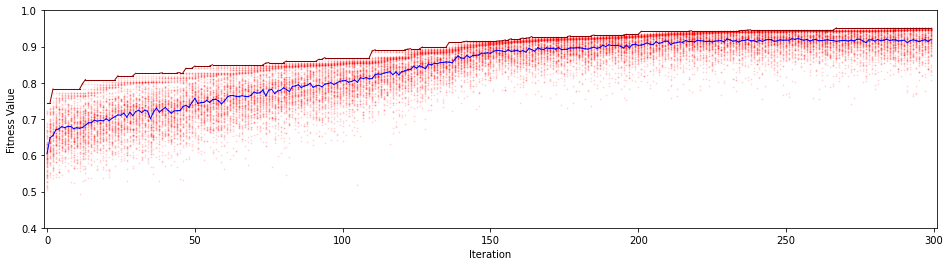

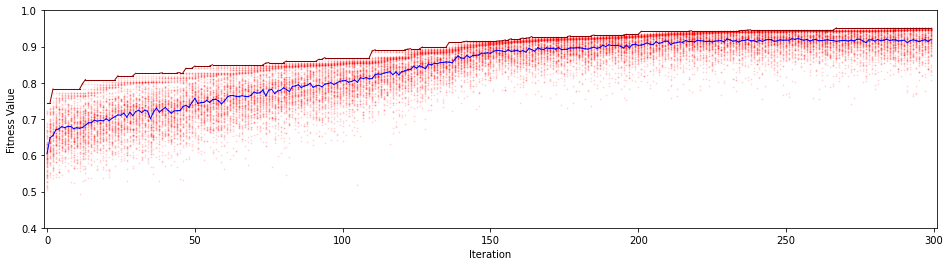

In [8]:
plt.figure(figsize=(16, 4))
plt.ylim(0.4, 1)
plt.xlim(-1, 301)
plt.xlabel('Iteration')
plt.ylabel('Fitness Value')
mean_scores = []
best_score = []
for i in range(300):
    display.clear_output(wait=True)
    best_boy = mdl.populate_next(1)
    print("itration -", i)
    print(f'{best_boy.fitness_:.5f} | Total gene - {sum(best_boy.chr)}')
    print(best_boy.frecord_)
    print(np.array(sorted(gene_names[best_boy.chr])))
    print(f"global best — {mdl.best_global_score:.4f} | {sum(mdl.best_global_pop.chr)}")
    print(np.array(sorted(gene_names[mdl.best_global_pop.chr])))

    mean_scores.append(mdl.fitness_.mean())
    best_score.append(best_boy.fitness_)
    plt.scatter([i]*mdl.n_pop, mdl.fitness_, color='red', s=1, alpha=0.10)
    if len(mean_scores) > 1: 
        plt.plot(range(i-1, i+1), mean_scores[-2:], c='blue', lw=1)
        plt.plot(range(i-1, i+1), best_score[-2:], c='darkred', lw=1)

    # plt.scatter(i, mean_scores[-1], c='dodgerblue', s=3)

    display.display(plt.gcf())

## save the model

In [83]:
with open('ga_model.pkl', 'wb') as f:
    pickle.dump(mdl, f)

Iteration - 299

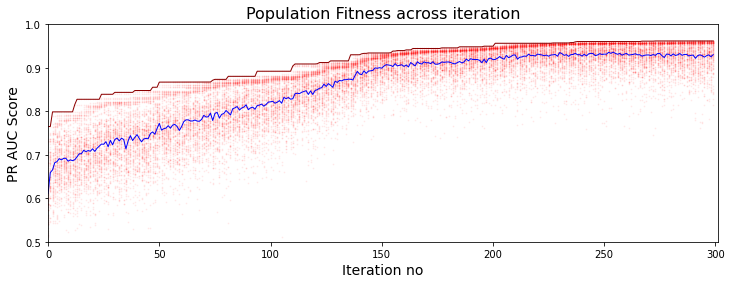

In [80]:
plt.figure(figsize=(12, 4))
plt.ylim(0.5, 1)
plt.xlim(0, 301)
plt.xlabel('Iteration no', fontsize=14)
plt.ylabel('PR AUC Score', fontsize=14)
plt.title("Population Fitness across iteration", fontsize=16)

max_arr = []
mean_arr = []
x_val_arr = []
for i, pop in enumerate(mdl.population_log):
    x_val, f2_val = [], []
    for p in pop:
        if hasattr(p, 'frecord_'):
            x_val.append(i)
            f2_val.append(p.frecord_['f2'])
        # else: break
    rt.iterLog(i)
    plt.scatter(x_val, f2_val, color='red', s=1, alpha=0.05)
    if f2_val:
        max_arr.append(max(f2_val))
        mean_arr.append(np.mean(f2_val))
        x_val_arr.append(i)

plt.plot(x_val_arr, mean_arr, c='blue', lw=1)
plt.plot(x_val_arr, max_arr, c='darkred', lw=1)
plt.show()

# Selecting the gobal best candidate

In [32]:
final_pop = mdl.best_global_pop

print(final_pop.frecord_)
print(final_pop is mdl.best_global_pop)
print(sum(final_pop.chr))
gene_names[final_pop.chr]

{'f1': 0.8119, 'f2': 0.9614, 'f3': 0.8802, 'var_oob': 0.0064, 'mean_boot': 1.0, 'var_boot': 0.0}
True
19


array(['ALDH3A1', 'PIR', 'ZNF444', 'CLTB', 'NUMA1', 'GCLM', 'BAG6',
       'HYOU1', 'RNF40', 'SLC25A11', 'ACTN4', 'HRAS', 'POLR2E', 'BBLN',
       'CD81', 'MRPL12', 'ECH1', 'FGFR3', 'NDUFV1'], dtype='<U10')

In [34]:
rt.writeln(gene_names[final_pop.chr])

ALDH3A1
PIR
ZNF444
CLTB
NUMA1
GCLM
BAG6
HYOU1
RNF40
SLC25A11
ACTN4
HRAS
POLR2E
BBLN
CD81
MRPL12
ECH1
FGFR3
NDUFV1


# Plot of gene Importance

In [35]:
n_boot = 1000
rnd = np.random.default_rng(37335)
coef_arr = []
score_arr = []
for i in range(n_boot):
    X_boot, X_oob, y_boot, y_oob = rt.bootstrap_resample(X[:, final_pop.chr], y, rnd_engine=rnd)
    scaler = StandardScaler()
    X_boot_scaled = scaler.fit_transform(X_boot)
    X_oob_scaled = scaler.transform(X_oob)

    svm.fit(X_boot_scaled, y_boot)
    coef_arr.append(svm.coef_[0])
    rt.iterLog(i)

    # y_oob_pred_proba = model.predict_proba(X_oob_std)[:, 1]
    score_arr.append(
        rt.pr_auc(y_oob, svm.predict_proba(X_oob_scaled)[:, 1])
    )

coef_arr = np.array(coef_arr)
score_arr = np.array(score_arr)
print()
print(score_arr.mean(), score_arr.var(ddof=1))

Iteration - 999
0.9669221760994915 0.00543637883340126


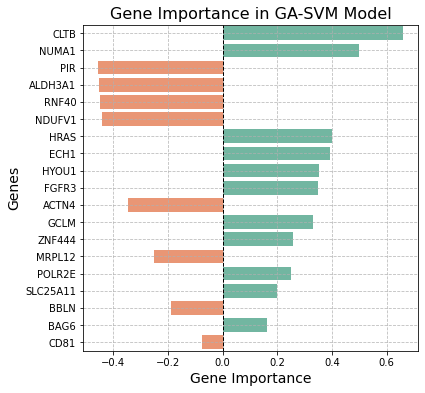

In [36]:
gene_importance = pd.Series(
    coef_arr.mean(0),
    index=gene_names[final_pop.chr]
)
gene_importance_sorted = gene_importance.reindex(gene_importance.abs().sort_values(ascending=False).index)
colors = ['Protective' if val < 0 else 'Risk' for val in gene_importance_sorted]


plt.figure(figsize=(6, 6))
sns.barplot(x=gene_importance_sorted.values, y=gene_importance_sorted.index, hue=colors, palette='Set2', legend=False)
plt.grid(axis="y", linestyle="--", alpha=0.85)


# Labels and Title
plt.xlabel("Gene Importance", fontsize=14)
plt.ylabel("Genes", fontsize=14)
plt.title("Gene Importance in GA-SVM Model", fontsize=16)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.85)


plt.show()

# Evaluations

In [72]:
svm = SVC(C=1, random_state=335, kernel='linear', class_weight='balanced', probability=True)
metric_list = (f1_score, roc_auc_score, balanced_accuracy_score, rt.pr_auc)

In [76]:
for i, met in enumerate(metric_list):
    boot, oob = rt.evaluateBootstrap(
        X, y, svm, final_pop.chr, n_boot=1000, use_proba=i%2, metric=met, seed=4324, boot_score=True
    )
    print(f'{met=}, {oob.mean()=}, {oob.var(ddof=0)=}')

met=<function f1_score at 0x1642e7380>, oob.mean()=0.8975800062682415, oob.var(ddof=0)=0.01925411740809448
met=<function roc_auc_score at 0x1643027a0>, oob.mean()=0.9775123805341873, oob.var(ddof=0)=0.003114475346049068
met=<function balanced_accuracy_score at 0x1642e7e20>, oob.mean()=0.9227977161727162, oob.var(ddof=0)=0.009659213891633435
met=<function pr_auc at 0x165bee980>, oob.mean()=0.9689282269905161, oob.var(ddof=0)=0.005090339657700008


In [79]:
for i, met in enumerate(metric_list):
    loo_score = rt.evaluateLOO(X, y, svm, final_pop.chr, use_proba=i%2, metric=met, verbose=1 if i==0 else 0)
    print(f'{met=}, {loo_score=}')

[[33  0]
 [ 1 13]]
met=<function f1_score at 0x1642e7380>, loo_score=0.9629629629629629
met=<function roc_auc_score at 0x1643027a0>, loo_score=1.0
met=<function balanced_accuracy_score at 0x1642e7e20>, loo_score=0.9642857142857143
met=<function pr_auc at 0x165bee980>, loo_score=0.9999999999999998
